<a href="https://colab.research.google.com/github/nisarg001/test_LSTM/blob/master/LSTM_StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

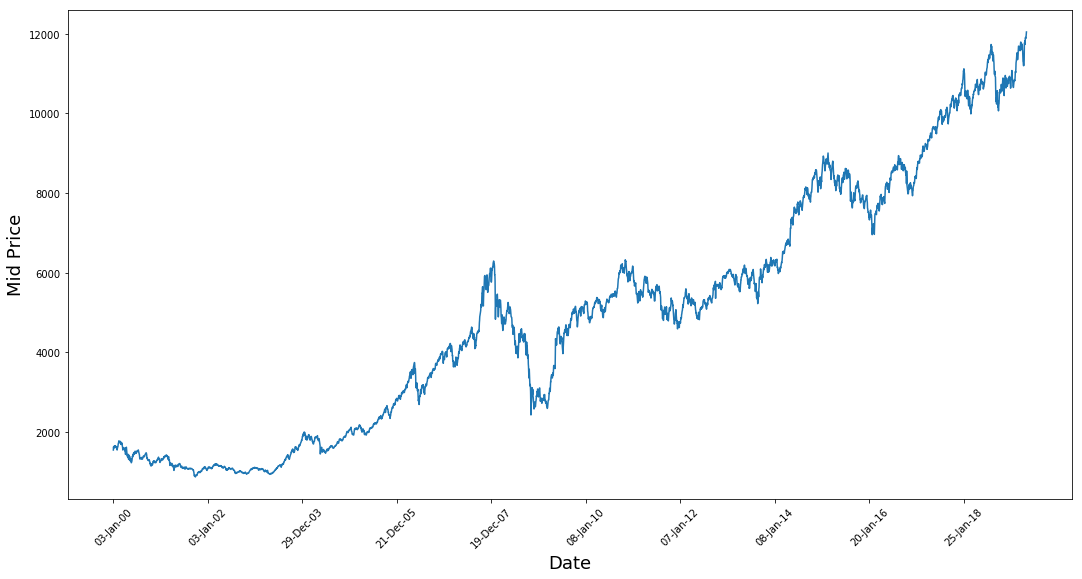

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


    Close  Volume
0  1592.2   25.36
1  1638.7   38.79
2  1595.8   62.15
3  1617.6   51.27
4  1613.3   54.32
(4350, 2)
0 1000
1000 1000
2000 1000
3000 1000
[[0.39486532 0.27303879]
 [0.40159335 0.29414075]
 [0.37796021 0.2535486 ]
 [0.38264798 0.42248618]
 [0.37397683 0.27074981]
 [0.3305482  0.30955412]
 [0.36047218 0.26633438]
 [0.34543732 0.30837577]
 [0.38466396 0.31703056]
 [0.3558087  0.31674613]
 [0.35906342 0.30341857]
 [0.31157854 0.33967656]
 [0.27159894 0.48804042]
 [0.33241845 0.3352205 ]
 [0.30472906 0.40864395]
 [0.32542323 0.27838877]
 [0.35942775 0.23897497]
 [0.34963931 0.30398743]
 [0.36076364 0.34364503]
 [0.3997474  0.2526005 ]
 [0.44558063 0.27119677]
 [0.44609069 0.30661502]
 [0.48247553 0.34295427]
 [0.48038668 0.32349117]
 [0.44052853 0.29003684]
 [0.47511598 0.29022646]
 [0.46170848 0.31107108]
 [0.45036555 0.29693087]
 [0.4761604  0.25776086]
 [0.51237522 0.31601474]
 [0.53644556 0.28364395]
 [0.53532827 0.2837523 ]
 [0.55247626 0.50632517]
 [0.606422   0.43546

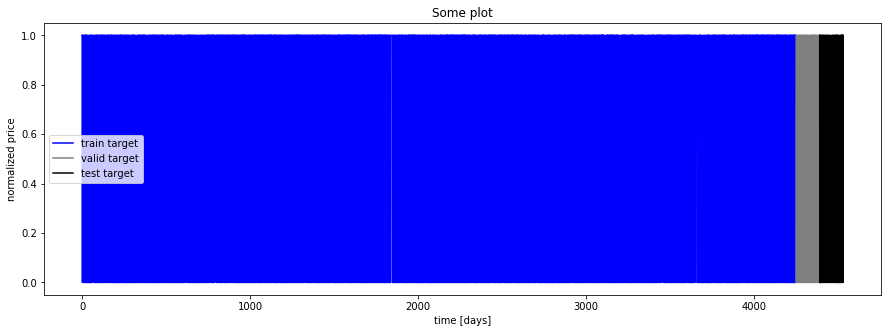

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('Nifty 50 Historical Data.csv',delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])

#values = df.values()

# Sort DataFrame by date
#df = df.sort_values('Date')

# Double check the result
df.head()

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

df['mid'] = (df['Low']+df['High'])/2.0

SEQ_LEN = 100  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0
      

df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))
df.tail()

times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.05*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

from collections import deque
import numpy as np
import random

train_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'mid','target'], inplace=True)
validation_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'mid','target'], inplace=True)
test_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'mid','target'], inplace=True)# don't need this anymore.
target_df = df['target'];
target_test_df = target_df[(target_df.index >= last_10pct)]
target_validation_df = target_df[(target_df.index >= last_20pct) & (target_df.index < last_10pct)]  
target_train_df = target_df[(target_df.index < last_20pct)]  # now the train_df is all the data up to the last 20%


print(train_df.head())
#train_data = train_df[RATIO_TO_PREDICT].as_matrix()
#valid_data = validation_df[RATIO_TO_PREDICT].as_matrix()
#test_data = test_df[RATIO_TO_PREDICT].as_matrix()

train_data = train_df.values
valid_data = validation_df.values
test_data = test_df.values
target_train_data = target_train_df.values
target_valid_data = target_validation_df.values
target_test_data = target_test_df.values



#train_data = train_data.reshape(-1,1)
#valid_data = valid_data.reshape(-1,1)
#test_data = test_data.reshape(-1,1)
print(train_data.shape)

scaler = MinMaxScaler()

# Train the Scaler with training data and smooth data
smoothing_window_size = 1000
for di in range(0,4000,smoothing_window_size):
    print(di, smoothing_window_size)
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
#train_data = train_data.reshape(-1)
#print(train_data)

# Normalize test data and validation data
scaler.fit(valid_data)
valid_data = scaler.transform(valid_data)
scaler.fit(test_data)
test_data = scaler.transform(test_data)
print(test_data)
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data) - FUTURE_PERIOD_PREDICT):
    X_train.append(train_data[i-SEQ_LEN:i,:])
    y_train.append(target_train_data[i-1 + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

print(X_train.shape)
print(y_train.shape)

X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)- FUTURE_PERIOD_PREDICT):
    X_valid.append(valid_data[i-SEQ_LEN:i,:])
    y_valid.append(target_valid_data[i-1+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))

X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)- FUTURE_PERIOD_PREDICT):
    X_test.append(test_data[i-SEQ_LEN:i,:])
    y_test.append(target_test_data[i-1+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

X_train_2 = []
y_train_2 = []
for i in range(SEQ_LEN, len(train_data)- FUTURE_PERIOD_PREDICT):
    X_train_2.append(train_data[i-SEQ_LEN:i])
    y_train_2.append(target_train_data[i-1 + (FUTURE_PERIOD_PREDICT-1)])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], X_train_2.shape[2]))

plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Some plot')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)



In [0]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
from tensorflow.keras import backend as K
import time

#LSTM Try
#EPOCHS = 10  # how many passes through our data
BATCH_SIZE = 1024  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model
EPOCHS_LSTM = 100
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LEN, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model

model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS_LSTM,
                    validation_data=(X_valid, y_valid))

predicted_stock_price_multi_head = model.predict(X_test, verbose=0)
#predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))
plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=18)
plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4249 samples, validate on 141 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4249/4249 [==============================] - 4s 997us/sample - loss: 0.5096 - val_loss: 0.4403
Epoch 2/100
4249/4249 [==============================] - 3s 683us/sample - loss: 0.4248 - val_loss: 0.3550
Epoch 3/100
4249/4249 [==============================] - 3s 675us/sample - loss: 0.3554 - val_loss: 0.2946
Epoch 4/100
4249/4249 [==============================] - 3s 674us/sample - loss: 0.3058 - val_loss: 0.2784
Epoch 5/100
4249/4249 [==============================] - 3s 690us/sample - loss: 0.2905 - val_loss: 0.2969
Epoch 6/100
4249/4249 [==============================] - 3s 675us/sample - loss: 0.2863 - val_loss: 0.2783
Epoch 7/100
4249/4249 [==============================] - 3s 671us/sample - loss: 0.2732 - val_loss: 0.2672
Epoch 8/100
4249/4249 [=============

In [0]:
#pred_inv = scaler.inverse_transform(predicted_stock_price_multi_head[:,0])
#print(pred_inv.shape)
print(predicted_stock_price_multi_head.shape)
print(y_test.shape)

print(y_test)


#aa = np.zeros((y_test.shape[0],1))
#y_test2 = np.append(y_test.reshape(y_test.shape[0],1), aa, axis = 1)
#y_test_inv = scaler.inverse_transform(y_test2)
#print(y_test_inv[:, 0])

#predicted_stock_price_multi_head2 = np.append(predicted_stock_price_multi_head, aa, axis=1)
#pred_inv = scaler.inverse_transform(predicted_stock_price_multi_head2)
#print(prev_inv[:, 0])
#y_test_inv = scaler.inverse_transform(y_test)
#print(y_test_inv)
#print(y_test_inv.shape)


(140, 1)
(140,)
[1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1
 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1
 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1]
